# Import libraries and set configs

In [2]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [4]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [5]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2044 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

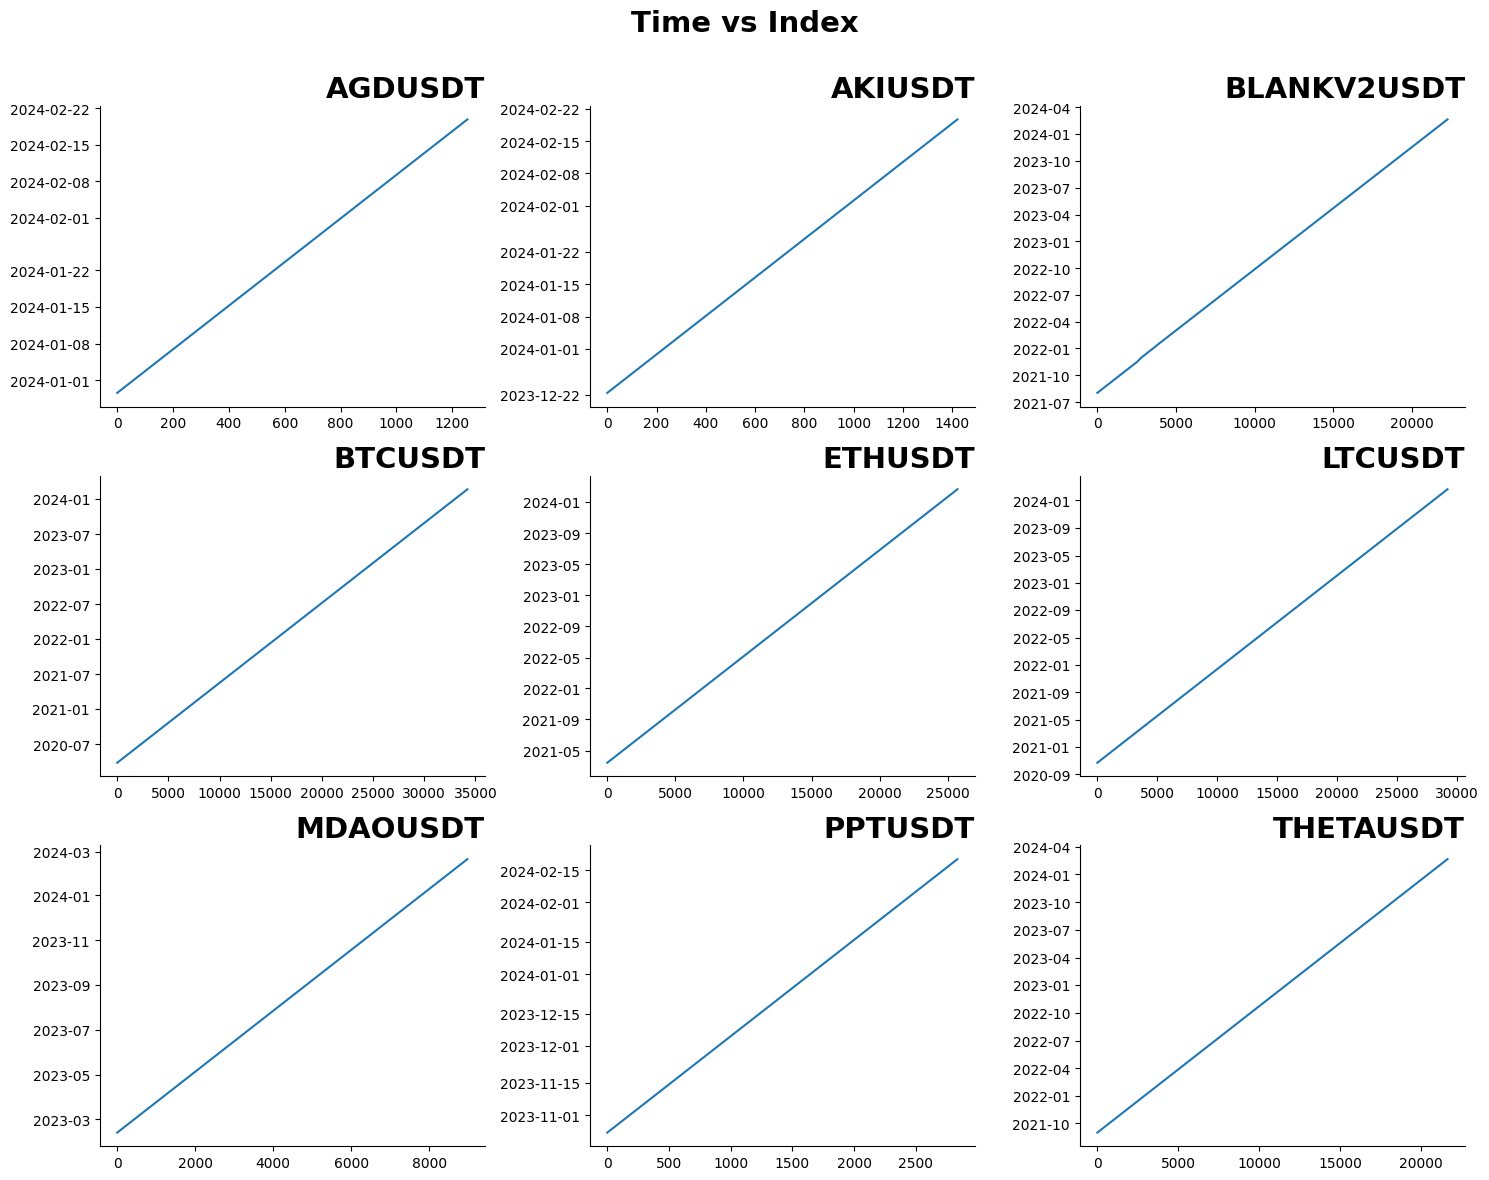

In [6]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [7]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare train data

In [11]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set sl flag and exit cycle if price crosses stop-loss threshold before it crosses take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1
                sl3 = pattern.startswith('Pattern') and ttype == 'buy' and target_sell_sl == 1
                sl4 = pattern.startswith('Pattern') and ttype == 'sell' and target_buy_sl == 1
                
                if sl1 or sl2 or sl3 or sl4:
                    break

                # set tp flag and exit cycle if price cross take-profit threshold and doesn't cross stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                tp3 = pattern.startswith('Pattern') and ttype == 'buy' and target_buy_tp == 1
                tp4 = pattern.startswith('Pattern') and ttype == 'sell' and target_sell_tp == 1
                    
                if tp1 or tp2 or tp3 or tp4:
                    row['target'] = 1
                    break
                
                # if price doesn't cross both tp and sl threshold but price above / below enter price for buy / sell trade - set tp flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price
                    l3 = pattern.startswith('Pattern') and ttype == 'buy' and last_price > close_price
                    l4 = pattern.startswith('Pattern') and ttype == 'sell' and last_price < close_price

                    if l1 or l2 or l3 or l4:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df

if CFG.create_dataset:
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
    price_cols = ['open','high', 'low', 'close']
    real_price_cols = ['real_high', 'real_low', 'real_close']
    funding_cols = ['funding_rate']
    rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
    btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
    btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 22, 23])]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([1, 9, 16, 17, 19, 21])]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    display(train_sell.head())
    display(train_sell.shape)


# Create train dataset

In [9]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    train_df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    train_df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    train_df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = train_df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

del df


# Data tests

### Test train dataframe columns

<AxesSubplot:title={'center':'Signal Time distribution'}>

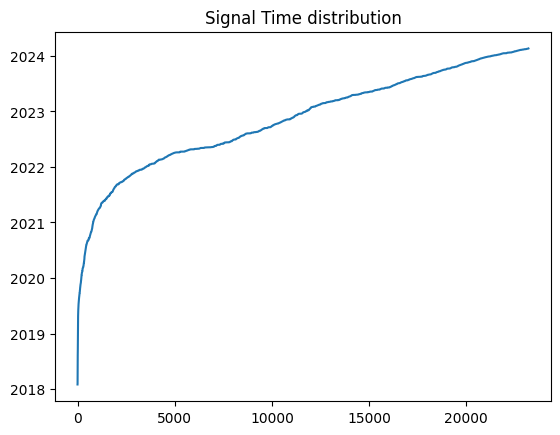

In [13]:
import re

# check if train dataset has only columns that we expect
cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                    btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
assert expected_cols == cols

# check RSI and STOCH columns, their values must be in [0, 100] range 
rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
for r_s_c in rsi_stoch_cols_:
    assert train_df[r_s_c].min() > -0.0001
    assert train_df[r_s_c].max() < 100.0001

# check volume columns, their values must be >= 0
vol_cols_ = [c for c in train_df.columns if 'volume' in c]
for v_c in vol_cols_:
    assert train_df[v_c].min() >= 0

# check funding columns, their period must be 8 hours
funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
for f_c in funding_cols_:
    num = ''.join([i for i in f_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 8 == 0

# check BTC dominance columns, their values must be in [0, 100] range 
# and their period must be 24 hours
btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
for b_c in btcd_cols_:
    # check values
    assert train_df[b_c].min() >= 0
    assert train_df[b_c].max() <= 100
    # check period
    num = ''.join([i for i in b_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 24 == 0

# check the rest columns, their period must be 4 hours
rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
for r_c in rest_cols_:
    num = ''.join([i for i in r_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 4 == 0

# check if changing of source dataframe doesn't affect the resulting train dataframe
# test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin([0])]
# assert test_df_buy_1.shape == test_df_buy_2.shape
# test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin([0])]
# assert test_df_sell_1.shape == test_df_sell_2.shape

# plot time values 
train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [14]:
if CFG.create_dataset:
    prev_ticker = None
    
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        low_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * (2 - CFG.cls_target_ratio_tp)
        high_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]

        tmp_df_1h = tmp_df_1h.iloc[idx+1:][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] <= tmp_df_1h['low_price'] 
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] >= tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            try:
                assert target == 0
            except:
                print(pattern, ticker, time_, target)
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal >= first_anti_signal

  0%|          | 0/17289 [00:00<?, ?it/s]

AssertionError: 

### Test sell target corectness

In [15]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        low_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * (2 - CFG.cls_target_ratio_tp)
        high_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]

        tmp_df_1h = tmp_df_1h.iloc[idx+1:][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

        tmp_df_1h['signal'] = tmp_df_1h['high'] >= tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] <= tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal >= first_anti_signal

  0%|          | 0/5908 [00:00<?, ?it/s]

AssertionError: 

### Test pattern / target distribution

In [19]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

if CFG.create_dataset:
    pvt = train_buy
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

    print('Buy')
    # display(pvt)
    display(pvt[pvt['pct'] >= 0.517])
    display(train_buy['ttype'].value_counts())
    display(train_buy[['target', 'pattern']].value_counts())
    display(train_buy[['target', 'pattern']].value_counts(normalize=True))

    pvt = train_sell
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

    print('Sell')
    # display(pvt)
    display(pvt[pvt['pct'] >= 0.517])
    display(train_sell['ttype'].value_counts())
    display(train_sell[['target', 'pattern']].value_counts())
    display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,711,1258,0.565183,"(0.5379, 0.5924)"
3,1,1,864,1608,0.537313,"(0.5131, 0.5616)"
5,2,1,814,1525,0.533770,"(0.5089, 0.5587)"
7,3,1,946,1797,0.526433,"(0.5035, 0.5494)"
11,16,1,772,1408,0.548295,"(0.5224, 0.5742)"
13,17,1,764,1424,0.536517,"(0.5107, 0.5623)"
15,19,1,628,1207,0.520298,"(0.4923, 0.5483)"
17,20,1,692,1322,0.523449,"(0.4967, 0.5502)"
19,21,1,804,1472,0.546196,"(0.5209, 0.5715)"
21,22,1,824,1479,0.557133,"(0.5319, 0.5823)"


buy    17289
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    9322
0       STOCH_RSI_Volume24    7967
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539187
0       STOCH_RSI_Volume24    0.460813
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
7,17,1,487,881,0.552781,"(0.5201, 0.5854)"
11,21,1,498,928,0.536638,"(0.5047, 0.5686)"


sell    5908
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    3079
0       STOCH_RSI_Volume24    2829
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.521158
0       STOCH_RSI_Volume24    0.478842
dtype: float64

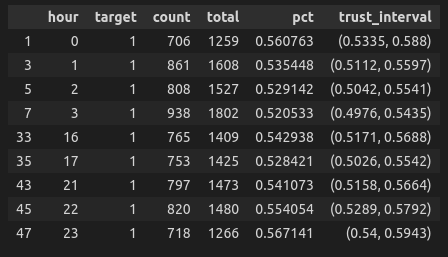

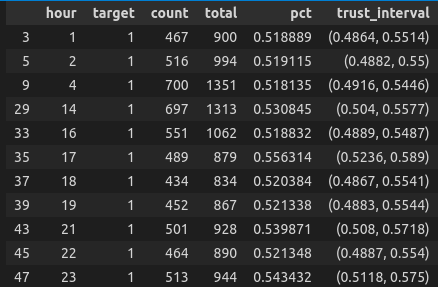

# Data visualization

### Visualize buy trades

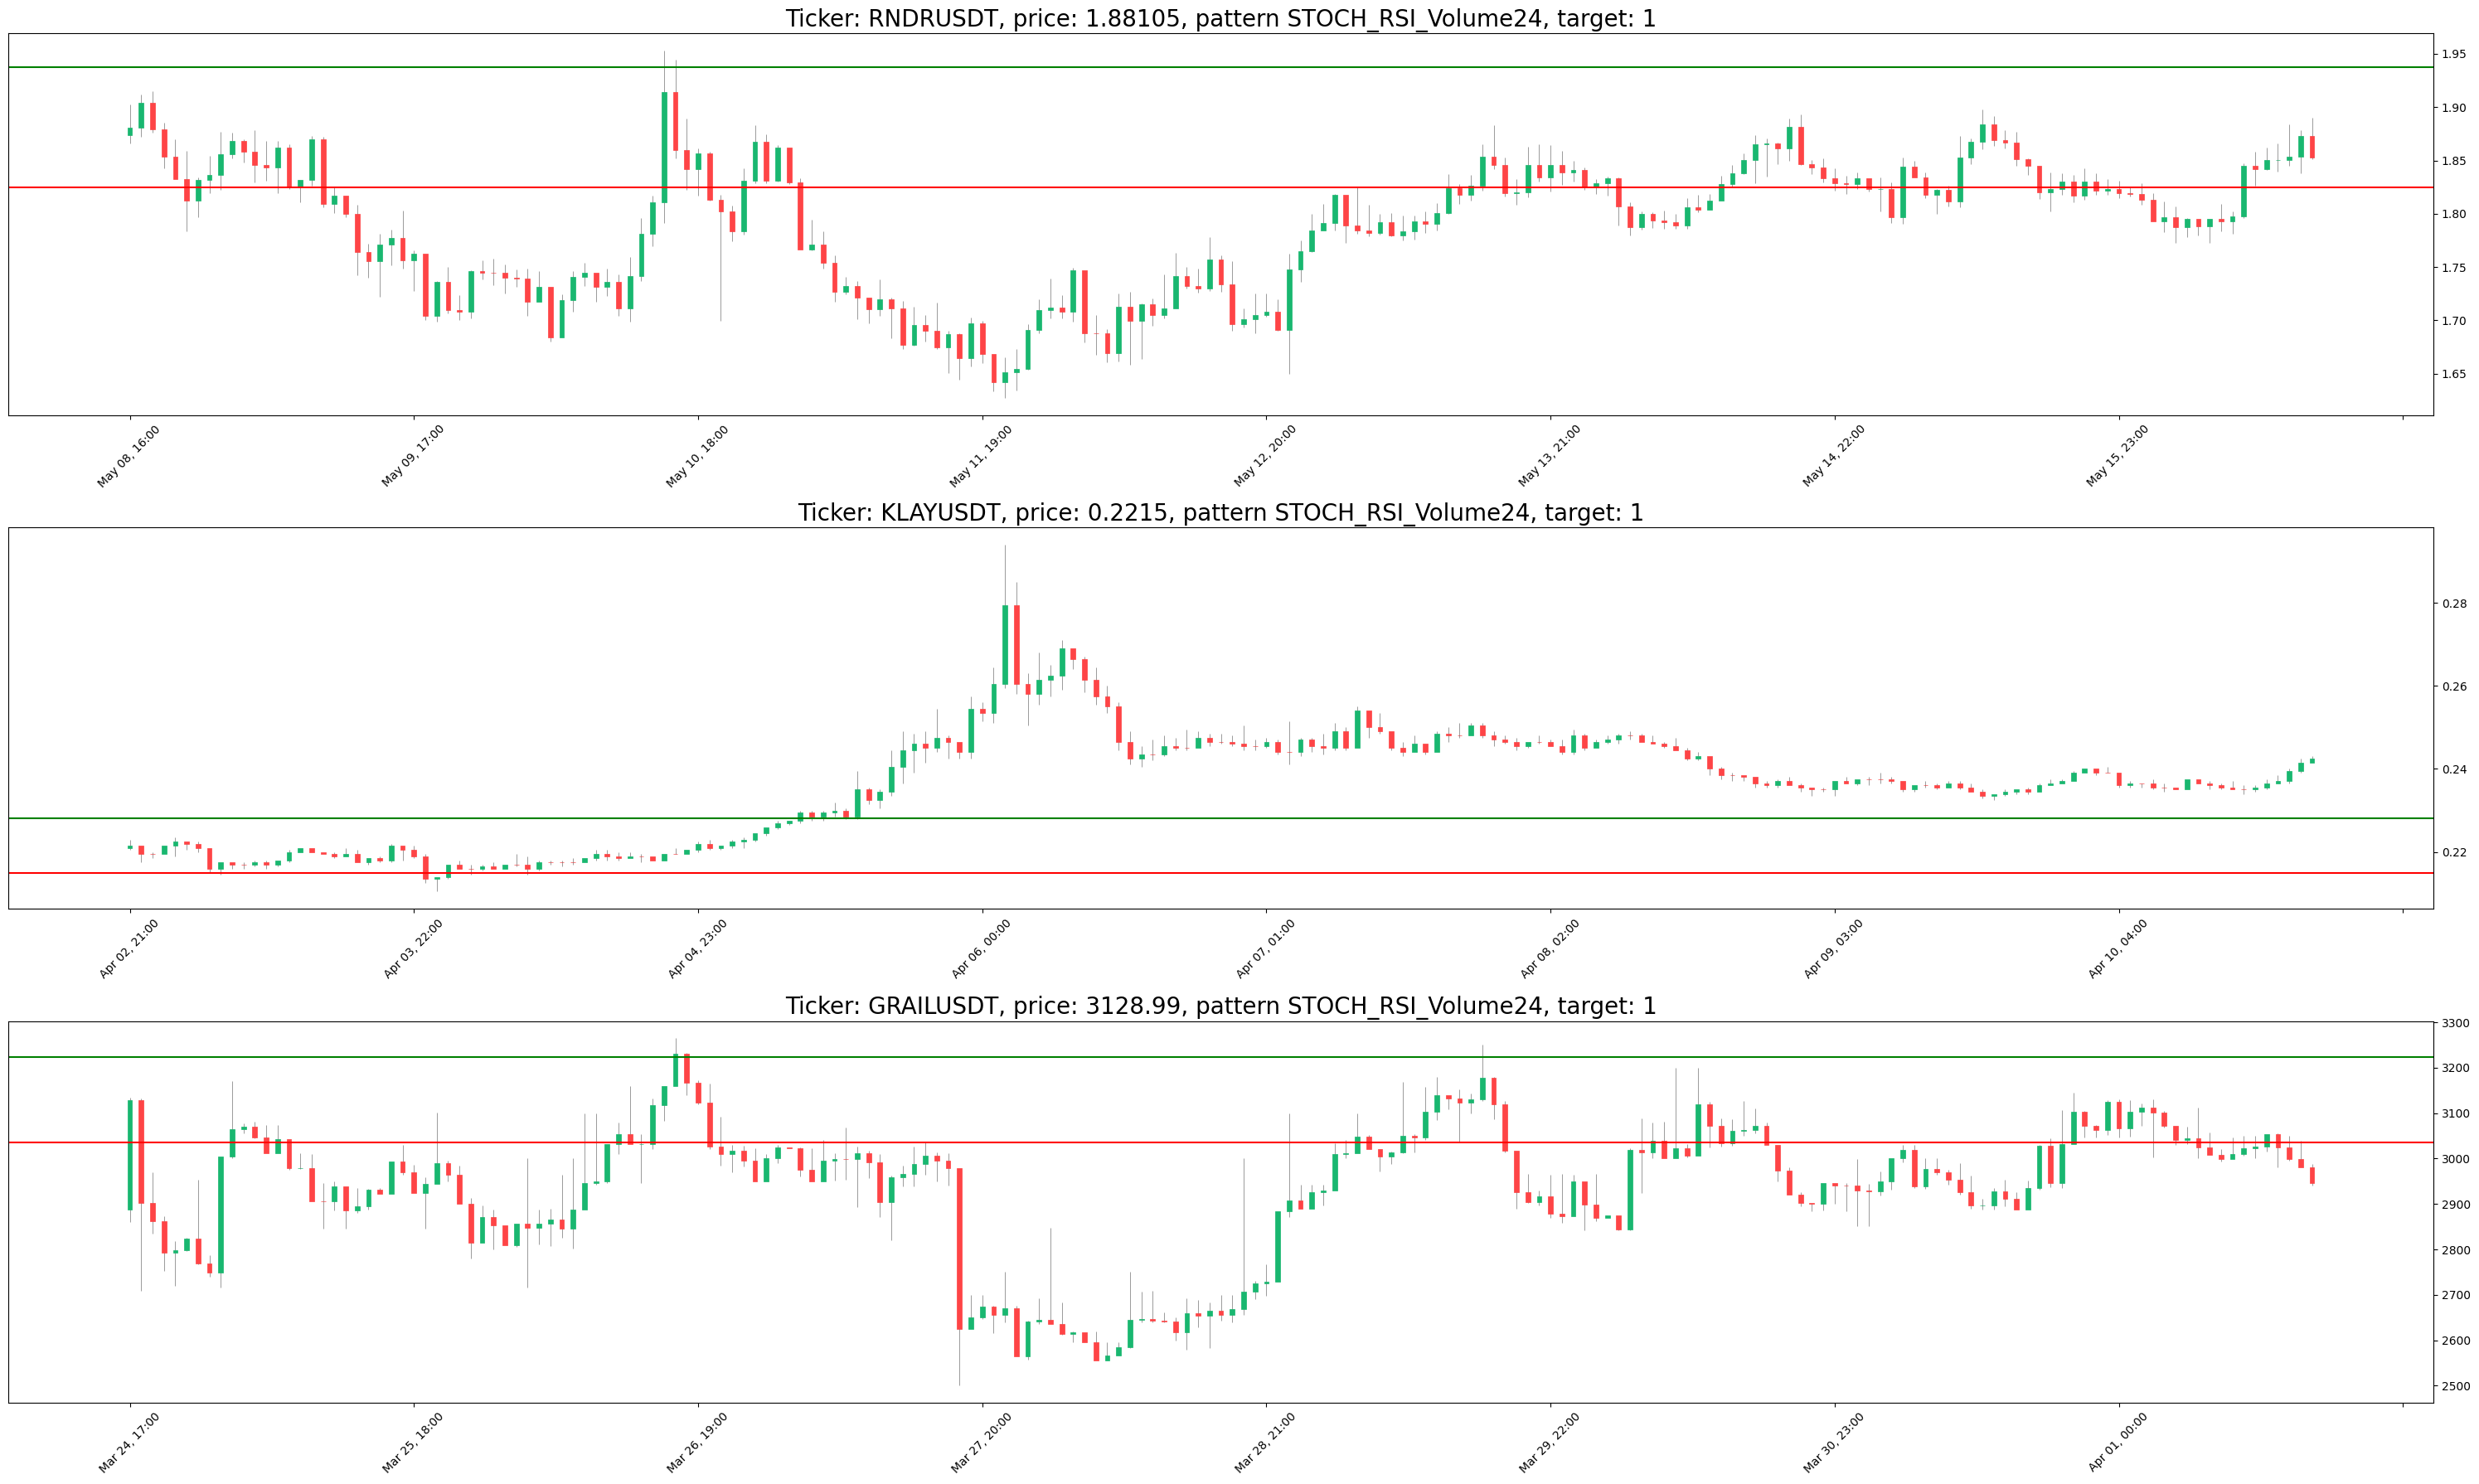

In [20]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    target_offset = 192
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

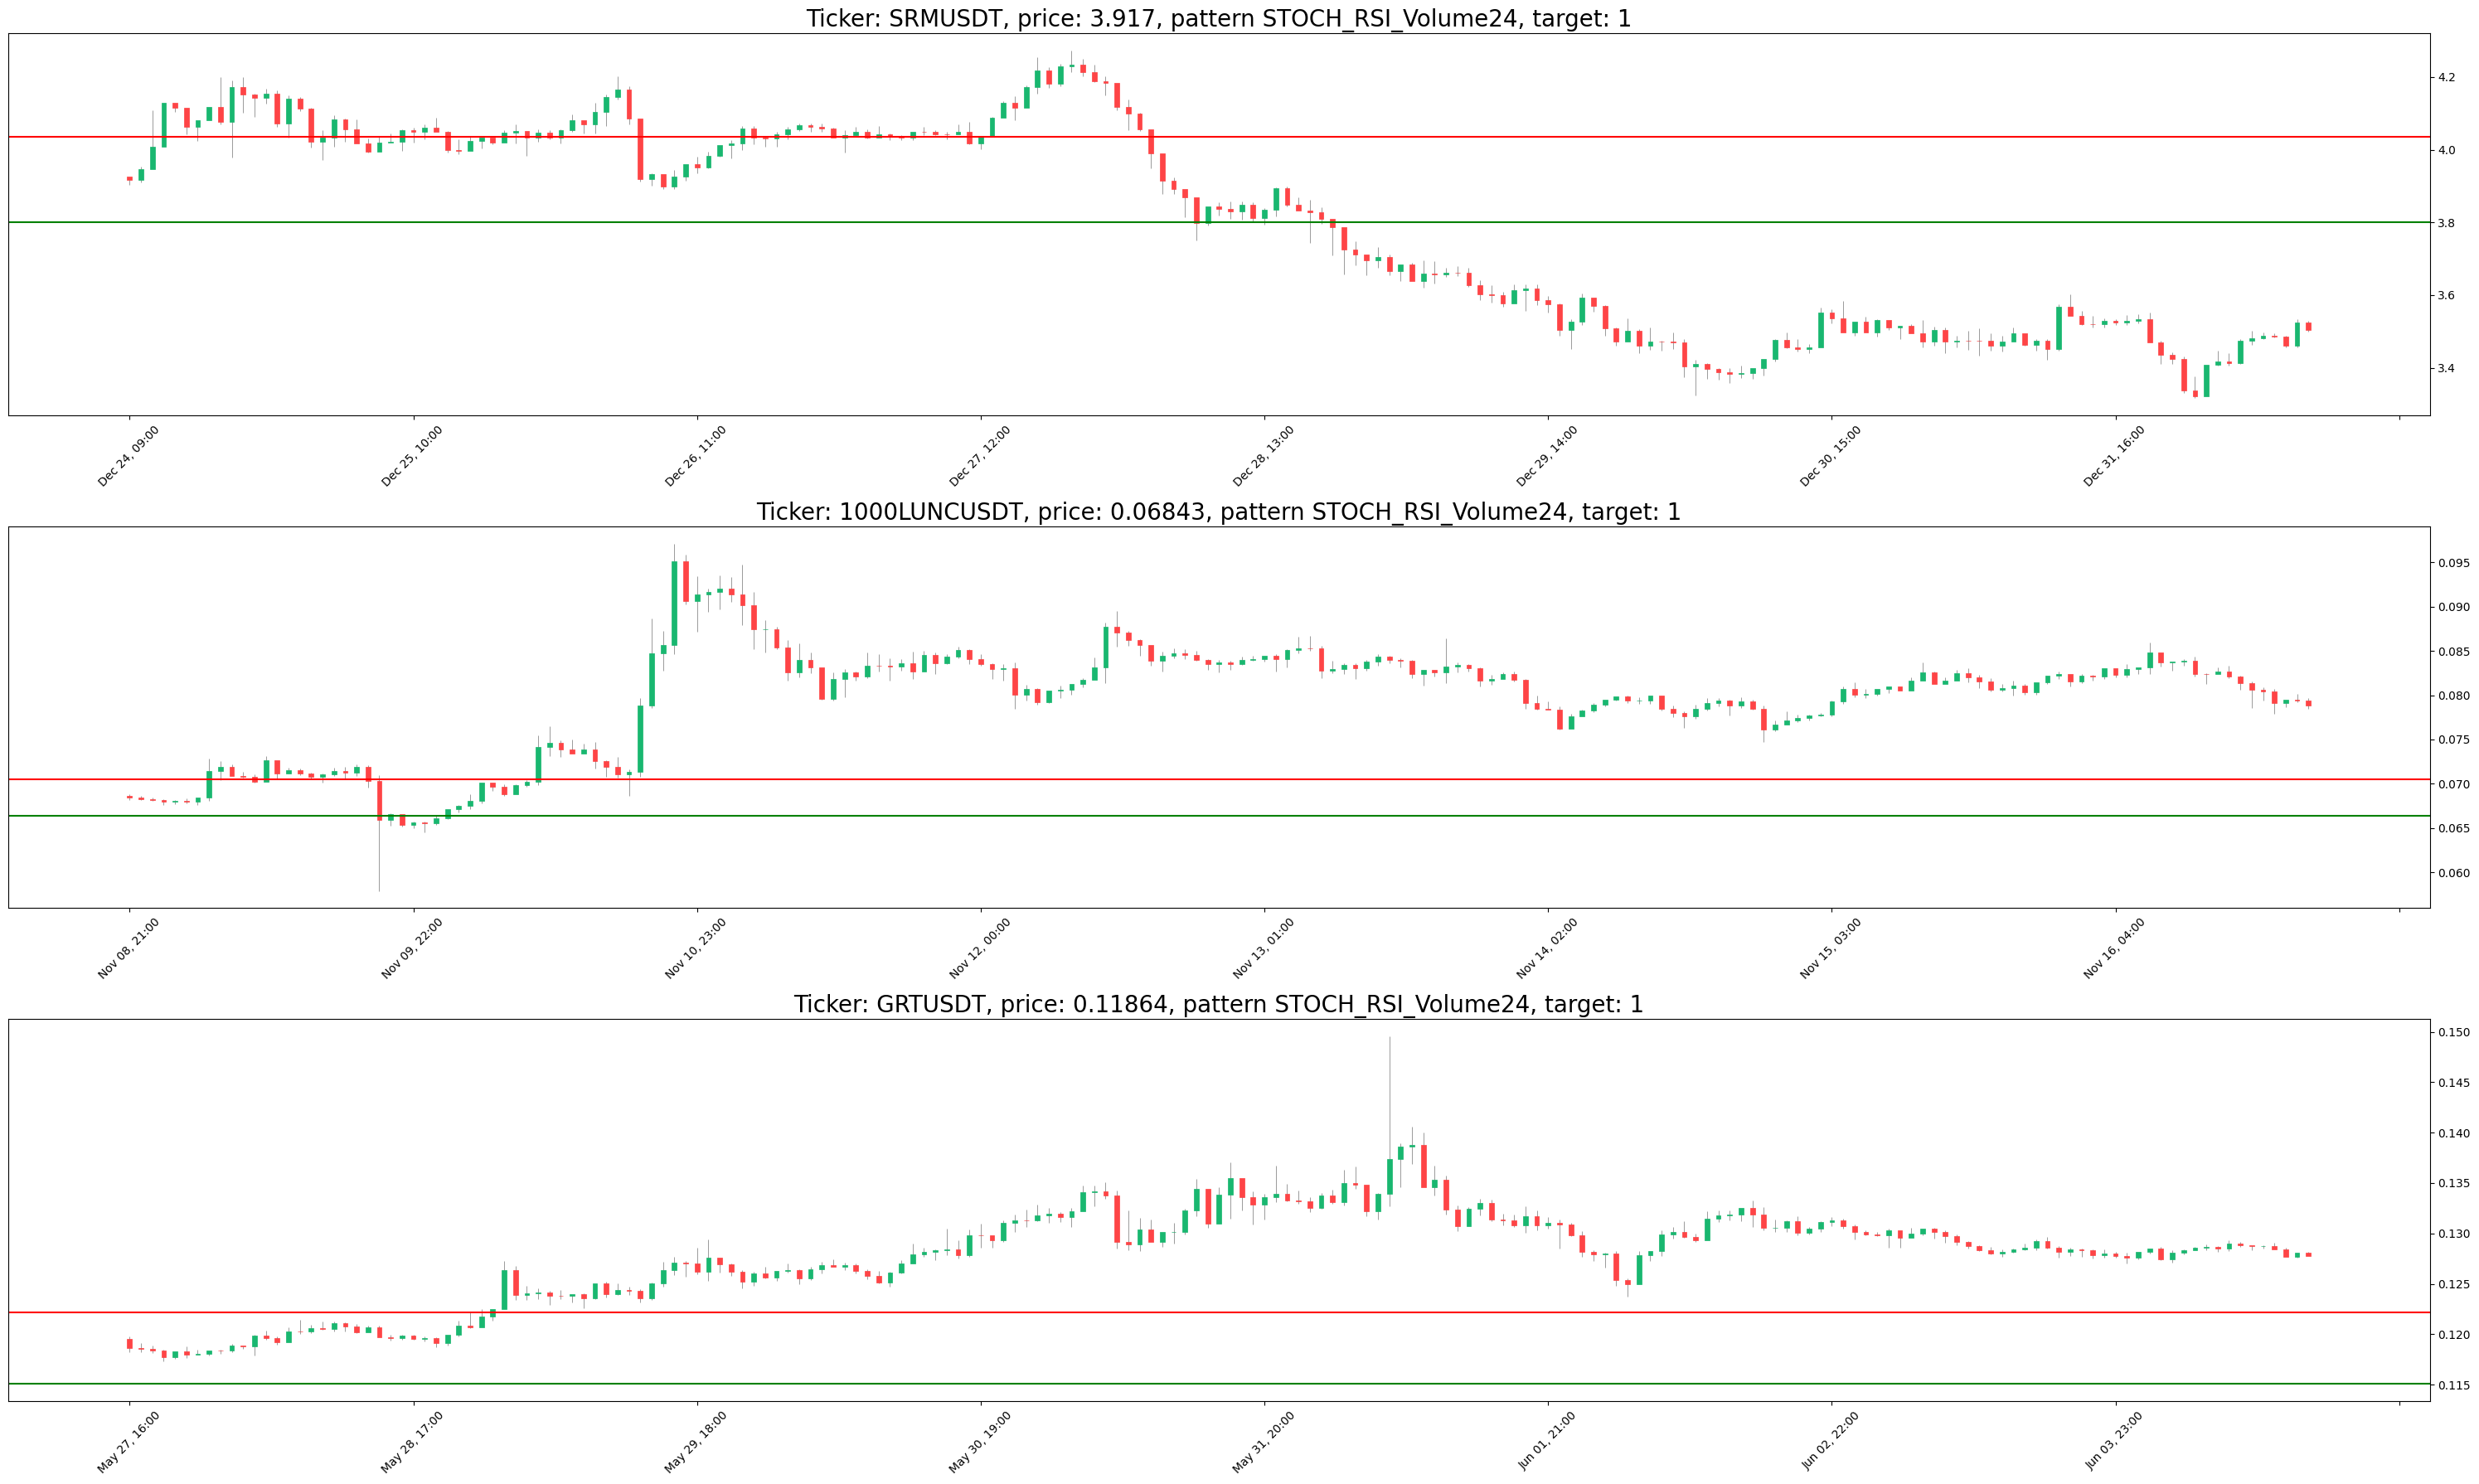

In [21]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

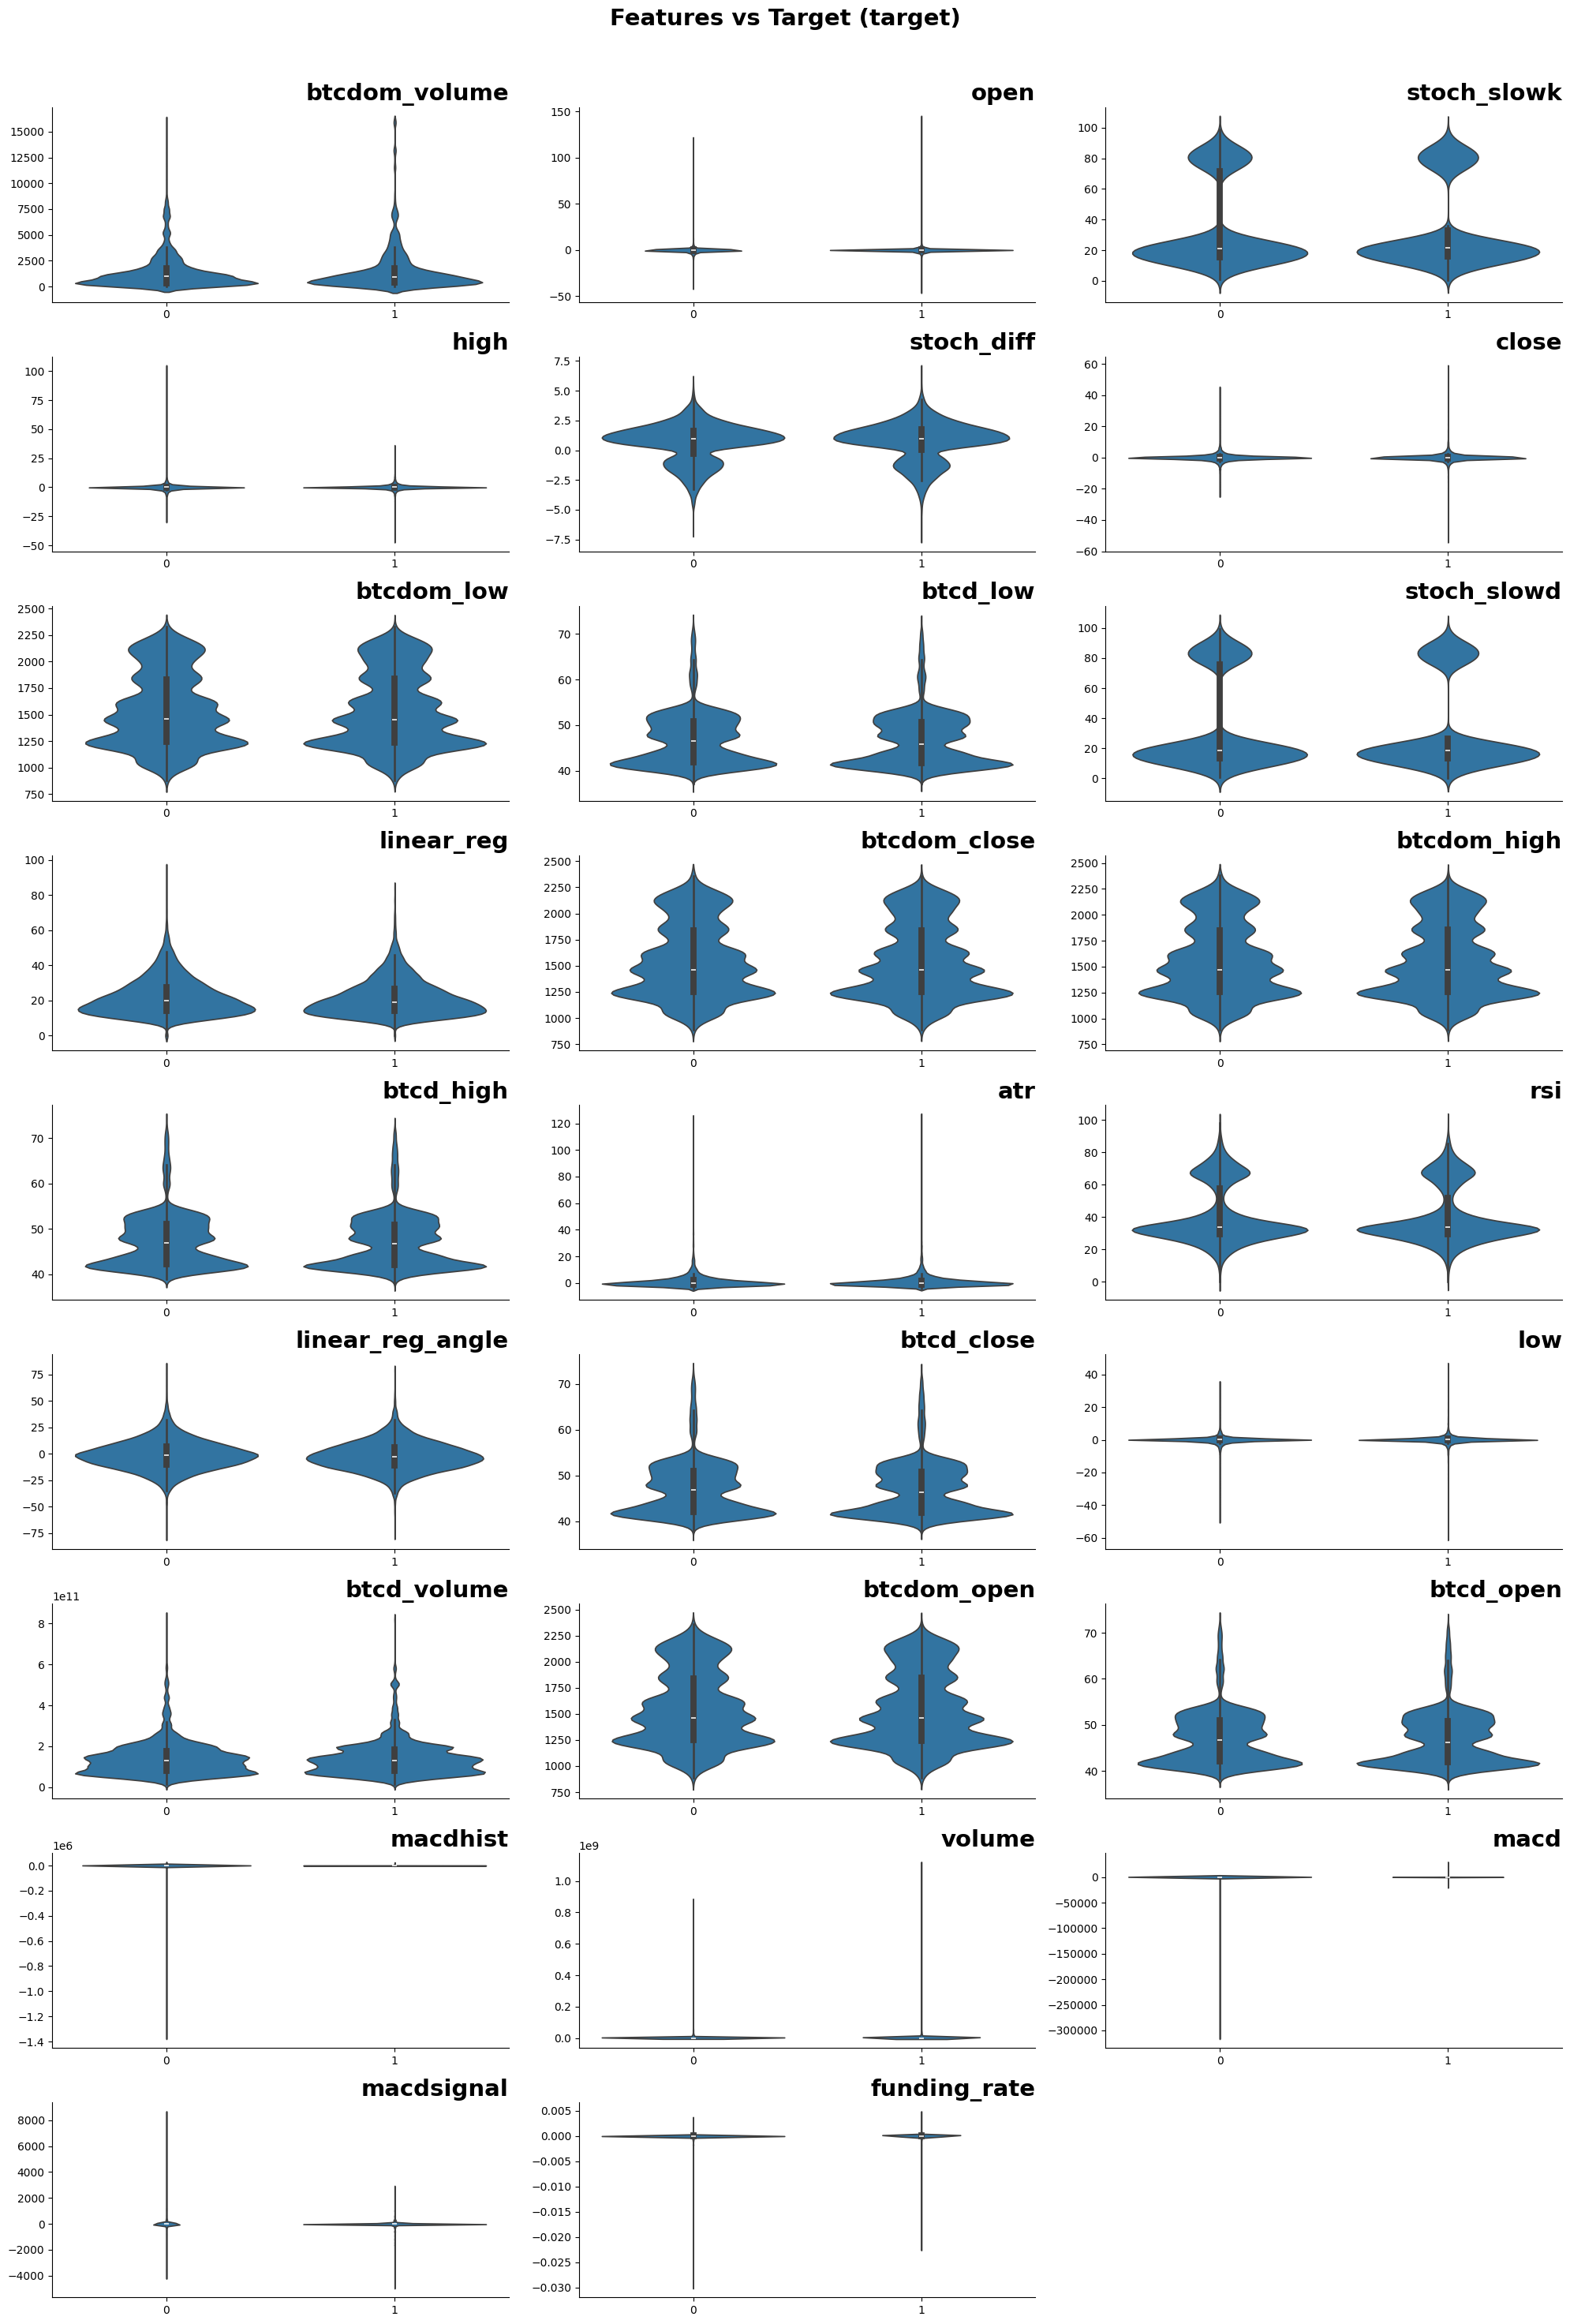

In [22]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [23]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
# x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
73533,2024-02-19 14:00:00,MINDUSDT,buy,STOCH_RSI_Volume24
73534,2024-02-19 14:00:00,PERPUSDT,sell,STOCH_RSI_Volume24
73535,2024-02-19 14:00:00,CGPTUSDT,sell,STOCH_RSI_Volume24
73536,2024-02-19 14:00:00,FORTUSDT,sell,STOCH_RSI_Volume24
73537,2024-02-19 14:00:00,WOIDUSDT,sell,STOCH_RSI_Volume24
73538,2024-02-19 14:00:00,PHBUSDT,sell,STOCH_RSI_Volume24
73539,2024-02-19 14:00:00,PEOPLEUSDT,sell,STOCH_RSI_Volume24
73540,2024-02-19 14:00:00,SAUCEUSDT,sell,STOCH_RSI_Volume24
73541,2024-02-19 14:00:00,GOGUSDT,sell,STOCH_RSI_Volume24
73542,2024-02-19 14:00:00,FILECOIN_USDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [24]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=400)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [25]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [26]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [27]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [28]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 430
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['btcdom_volume',
 'open',
 'stoch_slowk',
 'high',
 'stoch_diff',
 'close',
 'btcdom_low',
 'btcd_low',
 'stoch_slowd',
 'linear_reg',
 'btcdom_close',
 'btcdom_high',
 'btcd_high',
 'atr',
 'rsi',
 'linear_reg_angle',
 'btcd_close',
 'low',
 'low_prev_4',
 'atr_prev_4',
 'linear_reg_angle_prev_4',
 'close_prev_4',
 'stoch_slowd_prev_4',
 'volume_prev_4',
 'stoch_slowk_prev_4',
 'rsi_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_4',
 'btcdom_close_prev_4',
 'linear_reg_prev_4',
 'btcdom_volume_prev_8',
 'close_prev_8',
 'volume_prev_8',
 'low_prev_8',
 'rsi_prev_8',
 'stoch_diff_prev_8',
 'close_prev_12',
 'stoch_slowd_prev_12',
 'rsi_prev_12',
 'low_prev_12',
 'btcdom_low_prev_12',
 'btcdom_high_prev_12',
 'btcdom_volume_prev_12',
 'low_prev_16',
 'btcdom_volume_prev_16',
 'stoch_slowd_prev_16',
 'btcdom_open_prev_16',
 'btcdom_high_prev_16',
 'atr_prev_16',
 'btcdom_low_prev_16',
 'macdhist_prev_16',
 'stoch_diff_prev_16',
 'high_prev_16',
 'close_prev_16',
 'btcdom_volume_pre

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [29]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [30]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round(prec_obj_num * prec_score - prec_obj_num * (1 -prec_score))}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [31]:
params = {
    'boosting_type': 'goss',
    'n_estimators': 2935,
    'learning_rate': 0.000101,
    'max_depth': 10,
    'colsample_bytree': 0.86448,
    # 'subsample': 0.5394907029626385,
    'subsample_freq': 1,
    'num_leaves': 37,
    'verbosity': -1,
    'max_bin': 229,
    'reg_alpha': 0.050818,
    'reg_lambda': 2.192784e-08,
    'is_unbalance': True,
    'class_weight': 'balanced',
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precision'
    }

# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 1126,
#     'learning_rate': 0.0035991755858287514,
#     'max_depth': 6,
#     'colsample_bytree': 0.7437349346323546,
#     'subsample': 0.5394907029626385,
#     'subsample_freq': 1,
#     'num_leaves': 237,
#     'verbosity': -1,
#     'max_bin': 117,
#     'reg_alpha': 0.0003694000166537471,
#     'reg_lambda': 9.820784723776928,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'objective': 'binary',
#     'importance_type': 'gain',
#     'metric': 'average_precision'
#     }

train_test = 'fold' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))}')
elif train_test == 'full':
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')



    
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 431 features
Fold #1


1    0.546907
0    0.453093
Name: target, dtype: float64

Timestamp('2022-06-16 09:00:00')

Timestamp('2024-02-19 09:00:00')

[100]	training's binary_logloss: 0.69159	training's average_precision: 0.790279	valid_1's binary_logloss: 0.693187	valid_1's average_precision: 0.554882
[200]	training's binary_logloss: 0.69003	training's average_precision: 0.795622	valid_1's binary_logloss: 0.693272	valid_1's average_precision: 0.554651
[300]	training's binary_logloss: 0.68846	training's average_precision: 0.798122	valid_1's binary_logloss: 0.69341	valid_1's average_precision: 0.551735
[400]	training's binary_logloss: 0.686917	training's average_precision: 0.799024	valid_1's binary_logloss: 0.693558	valid_1's average_precision: 0.550668
[500]	training's binary_logloss: 0.6854	training's average_precision: 0.799573	valid_1's binary_logloss: 0.693724	valid_1's average_precision: 0.550133
[600]	training's binary_logloss: 0.6839	training's average_precision: 0.80067	valid_1's binary_logloss: 0.693902	valid_1's average_precision: 0.549259
[700]	training's binary_logloss: 0.682425	training's average_precision: 0.801578	vali

1    0.553978
0    0.446022
Name: target, dtype: float64

Timestamp('2022-11-13 19:00:00')

Timestamp('2024-02-19 09:00:00')

[100]	training's binary_logloss: 0.691731	training's average_precision: 0.764603	valid_1's binary_logloss: 0.692823	valid_1's average_precision: 0.606676
[200]	training's binary_logloss: 0.690324	training's average_precision: 0.769168	valid_1's binary_logloss: 0.692571	valid_1's average_precision: 0.604746
[300]	training's binary_logloss: 0.688934	training's average_precision: 0.768203	valid_1's binary_logloss: 0.692318	valid_1's average_precision: 0.60412
[400]	training's binary_logloss: 0.687566	training's average_precision: 0.768645	valid_1's binary_logloss: 0.692035	valid_1's average_precision: 0.603924
[500]	training's binary_logloss: 0.686212	training's average_precision: 0.768988	valid_1's binary_logloss: 0.691807	valid_1's average_precision: 0.603454
[600]	training's binary_logloss: 0.684876	training's average_precision: 0.77001	valid_1's binary_logloss: 0.691524	valid_1's average_precision: 0.602894
[700]	training's binary_logloss: 0.683557	training's average_precision: 0.7718

1    0.556746
0    0.443254
Name: target, dtype: float64

Timestamp('2023-04-09 15:00:00')

Timestamp('2024-02-19 09:00:00')

[100]	training's binary_logloss: 0.691739	training's average_precision: 0.755034	valid_1's binary_logloss: 0.693119	valid_1's average_precision: 0.590683
[200]	training's binary_logloss: 0.690357	training's average_precision: 0.758141	valid_1's binary_logloss: 0.693033	valid_1's average_precision: 0.590199
[300]	training's binary_logloss: 0.688988	training's average_precision: 0.756389	valid_1's binary_logloss: 0.692999	valid_1's average_precision: 0.59167
[400]	training's binary_logloss: 0.687642	training's average_precision: 0.756394	valid_1's binary_logloss: 0.69297	valid_1's average_precision: 0.590714
[500]	training's binary_logloss: 0.68632	training's average_precision: 0.756614	valid_1's binary_logloss: 0.692946	valid_1's average_precision: 0.593253
[600]	training's binary_logloss: 0.685018	training's average_precision: 0.756518	valid_1's binary_logloss: 0.692946	valid_1's average_precision: 0.593927
[700]	training's binary_logloss: 0.683738	training's average_precision: 0.75795

1    0.579178
0    0.420822
Name: target, dtype: float64

Timestamp('2023-07-30 22:00:00')

Timestamp('2024-02-19 09:00:00')

[100]	training's binary_logloss: 0.691869	training's average_precision: 0.741397	valid_1's binary_logloss: 0.693136	valid_1's average_precision: 0.648899
[200]	training's binary_logloss: 0.690611	training's average_precision: 0.743262	valid_1's binary_logloss: 0.693105	valid_1's average_precision: 0.647062
[300]	training's binary_logloss: 0.689375	training's average_precision: 0.741505	valid_1's binary_logloss: 0.693098	valid_1's average_precision: 0.645965
[400]	training's binary_logloss: 0.68816	training's average_precision: 0.741515	valid_1's binary_logloss: 0.693085	valid_1's average_precision: 0.645459
[500]	training's binary_logloss: 0.686959	training's average_precision: 0.741488	valid_1's binary_logloss: 0.693066	valid_1's average_precision: 0.64496
[600]	training's binary_logloss: 0.685777	training's average_precision: 0.741358	valid_1's binary_logloss: 0.69304	valid_1's average_precision: 0.645411
[700]	training's binary_logloss: 0.684612	training's average_precision: 0.74209

1    0.548627
0    0.451373
Name: target, dtype: float64

Timestamp('2023-11-24 09:00:00')

Timestamp('2024-02-19 09:00:00')

[100]	training's binary_logloss: 0.692054	training's average_precision: 0.731078	valid_1's binary_logloss: 0.69281	valid_1's average_precision: 0.661814
[200]	training's binary_logloss: 0.690975	training's average_precision: 0.733556	valid_1's binary_logloss: 0.692451	valid_1's average_precision: 0.669675
[300]	training's binary_logloss: 0.68991	training's average_precision: 0.732372	valid_1's binary_logloss: 0.692119	valid_1's average_precision: 0.669323
[400]	training's binary_logloss: 0.688867	training's average_precision: 0.732083	valid_1's binary_logloss: 0.691777	valid_1's average_precision: 0.670309
[500]	training's binary_logloss: 0.687837	training's average_precision: 0.732341	valid_1's binary_logloss: 0.691413	valid_1's average_precision: 0.67028
[600]	training's binary_logloss: 0.686828	training's average_precision: 0.732642	valid_1's binary_logloss: 0.690997	valid_1's average_precision: 0.671294
[700]	training's binary_logloss: 0.685831	training's average_precision: 0.73350

In [32]:
# Training with 431 features
# Fold #1
# 1    0.546907
# 0    0.453093
# Name: target, dtype: float64Timestamp('2022-06-16 09:00:00')Timestamp('2024-02-19 09:00:00')
# [100]	training's binary_logloss: 0.69159	training's average_precision: 0.790279	valid_1's binary_logloss: 0.693187	valid_1's average_precision: 0.554882
# [200]	training's binary_logloss: 0.69003	training's average_precision: 0.795622	valid_1's binary_logloss: 0.693272	valid_1's average_precision: 0.554651
# [300]	training's binary_logloss: 0.68846	training's average_precision: 0.798122	valid_1's binary_logloss: 0.69341	valid_1's average_precision: 0.551735
# [400]	training's binary_logloss: 0.686917	training's average_precision: 0.799024	valid_1's binary_logloss: 0.693558	valid_1's average_precision: 0.550668
# [500]	training's binary_logloss: 0.6854	training's average_precision: 0.799573	valid_1's binary_logloss: 0.693724	valid_1's average_precision: 0.550133
# [600]	training's binary_logloss: 0.6839	training's average_precision: 0.80067	valid_1's binary_logloss: 0.693902	valid_1's average_precision: 0.549259
# [700]	training's binary_logloss: 0.682425	training's average_precision: 0.801578	valid_1's binary_logloss: 0.694086	valid_1's average_precision: 0.54931
# [800]	training's binary_logloss: 0.680956	training's average_precision: 0.801975	valid_1's binary_logloss: 0.694302	valid_1's average_precision: 0.548346
# [900]	training's binary_logloss: 0.679507	training's average_precision: 0.803025	valid_1's binary_logloss: 0.694524	valid_1's average_precision: 0.547707
# [1000]	training's binary_logloss: 0.678079	training's average_precision: 0.803975	valid_1's binary_logloss: 0.694762	valid_1's average_precision: 0.54798
# [1100]	training's binary_logloss: 0.676668	training's average_precision: 0.804776	valid_1's binary_logloss: 0.694964	valid_1's average_precision: 0.54791
# [1200]	training's binary_logloss: 0.675267	training's average_precision: 0.805129	valid_1's binary_logloss: 0.695119	valid_1's average_precision: 0.547706
# [1300]	training's binary_logloss: 0.673872	training's average_precision: 0.806024	valid_1's binary_logloss: 0.695288	valid_1's average_precision: 0.547261
# [1400]	training's binary_logloss: 0.672501	training's average_precision: 0.806583	valid_1's binary_logloss: 0.695471	valid_1's average_precision: 0.54693
# [1500]	training's binary_logloss: 0.671146	training's average_precision: 0.807259	valid_1's binary_logloss: 0.695646	valid_1's average_precision: 0.546673
# [1600]	training's binary_logloss: 0.669805	training's average_precision: 0.808166	valid_1's binary_logloss: 0.69584	valid_1's average_precision: 0.546522
# [1700]	training's binary_logloss: 0.66848	training's average_precision: 0.808952	valid_1's binary_logloss: 0.696034	valid_1's average_precision: 0.546679
# [1800]	training's binary_logloss: 0.667174	training's average_precision: 0.808985	valid_1's binary_logloss: 0.696227	valid_1's average_precision: 0.546817
# [1900]	training's binary_logloss: 0.665878	training's average_precision: 0.809306	valid_1's binary_logloss: 0.696441	valid_1's average_precision: 0.546783
# [2000]	training's binary_logloss: 0.664604	training's average_precision: 0.809683	valid_1's binary_logloss: 0.696658	valid_1's average_precision: 0.546644
# [2100]	training's binary_logloss: 0.663337	training's average_precision: 0.809917	valid_1's binary_logloss: 0.696874	valid_1's average_precision: 0.546662
# [2200]	training's binary_logloss: 0.662083	training's average_precision: 0.810364	valid_1's binary_logloss: 0.697089	valid_1's average_precision: 0.546707
# [2300]	training's binary_logloss: 0.660846	training's average_precision: 0.810818	valid_1's binary_logloss: 0.697292	valid_1's average_precision: 0.54685
# [2400]	training's binary_logloss: 0.659625	training's average_precision: 0.811097	valid_1's binary_logloss: 0.697515	valid_1's average_precision: 0.547025
# [2500]	training's binary_logloss: 0.658422	training's average_precision: 0.811747	valid_1's binary_logloss: 0.697726	valid_1's average_precision: 0.547042
# [2600]	training's binary_logloss: 0.657233	training's average_precision: 0.812321	valid_1's binary_logloss: 0.697945	valid_1's average_precision: 0.547265
# [2700]	training's binary_logloss: 0.65605	training's average_precision: 0.812932	valid_1's binary_logloss: 0.698162	valid_1's average_precision: 0.547694
# [2800]	training's binary_logloss: 0.654891	training's average_precision: 0.81344	valid_1's binary_logloss: 0.698385	valid_1's average_precision: 0.548138
# [2900]	training's binary_logloss: 0.653724	training's average_precision: 0.814114	valid_1's binary_logloss: 0.69863	valid_1's average_precision: 0.548482
# Logloss: 0.6986893410171773, Confident objects precision: 0.5281079344683585
# Number of confident objects 3113, % of confident objects: 0.39787832310838445
# Number of profitable objects: 175
# Fold #2
# 1    0.553978
# 0    0.446022
# Name: target, dtype: float64Timestamp('2022-11-13 19:00:00')Timestamp('2024-02-19 09:00:00')
# [100]	training's binary_logloss: 0.691731	training's average_precision: 0.764603	valid_1's binary_logloss: 0.692823	valid_1's average_precision: 0.606676
# [200]	training's binary_logloss: 0.690324	training's average_precision: 0.769168	valid_1's binary_logloss: 0.692571	valid_1's average_precision: 0.604746
# [300]	training's binary_logloss: 0.688934	training's average_precision: 0.768203	valid_1's binary_logloss: 0.692318	valid_1's average_precision: 0.60412
# [400]	training's binary_logloss: 0.687566	training's average_precision: 0.768645	valid_1's binary_logloss: 0.692035	valid_1's average_precision: 0.603924
# [500]	training's binary_logloss: 0.686212	training's average_precision: 0.768988	valid_1's binary_logloss: 0.691807	valid_1's average_precision: 0.603454
# [600]	training's binary_logloss: 0.684876	training's average_precision: 0.77001	valid_1's binary_logloss: 0.691524	valid_1's average_precision: 0.602894
# [700]	training's binary_logloss: 0.683557	training's average_precision: 0.77189	valid_1's binary_logloss: 0.691231	valid_1's average_precision: 0.602133
# [800]	training's binary_logloss: 0.682252	training's average_precision: 0.773047	valid_1's binary_logloss: 0.690951	valid_1's average_precision: 0.602027
# [900]	training's binary_logloss: 0.680964	training's average_precision: 0.773924	valid_1's binary_logloss: 0.690688	valid_1's average_precision: 0.601473
# [1000]	training's binary_logloss: 0.679692	training's average_precision: 0.774813	valid_1's binary_logloss: 0.690408	valid_1's average_precision: 0.600991
# [1100]	training's binary_logloss: 0.678438	training's average_precision: 0.775568	valid_1's binary_logloss: 0.690181	valid_1's average_precision: 0.600528
# [1200]	training's binary_logloss: 0.677198	training's average_precision: 0.775914	valid_1's binary_logloss: 0.689938	valid_1's average_precision: 0.600194
# [1300]	training's binary_logloss: 0.675975	training's average_precision: 0.776481	valid_1's binary_logloss: 0.689709	valid_1's average_precision: 0.599866
# [1400]	training's binary_logloss: 0.674771	training's average_precision: 0.776732	valid_1's binary_logloss: 0.689457	valid_1's average_precision: 0.599849
# [1500]	training's binary_logloss: 0.673579	training's average_precision: 0.777127	valid_1's binary_logloss: 0.689235	valid_1's average_precision: 0.599643
# [1600]	training's binary_logloss: 0.672405	training's average_precision: 0.777387	valid_1's binary_logloss: 0.689031	valid_1's average_precision: 0.59975
# [1700]	training's binary_logloss: 0.671247	training's average_precision: 0.777639	valid_1's binary_logloss: 0.688833	valid_1's average_precision: 0.599799
# [1800]	training's binary_logloss: 0.670103	training's average_precision: 0.778154	valid_1's binary_logloss: 0.688663	valid_1's average_precision: 0.599716
# [1900]	training's binary_logloss: 0.668974	training's average_precision: 0.778548	valid_1's binary_logloss: 0.688498	valid_1's average_precision: 0.59969
# [2000]	training's binary_logloss: 0.66786	training's average_precision: 0.778939	valid_1's binary_logloss: 0.688353	valid_1's average_precision: 0.599549
# [2100]	training's binary_logloss: 0.666757	training's average_precision: 0.779332	valid_1's binary_logloss: 0.688194	valid_1's average_precision: 0.59932
# [2200]	training's binary_logloss: 0.665665	training's average_precision: 0.779787	valid_1's binary_logloss: 0.688071	valid_1's average_precision: 0.599089
# [2300]	training's binary_logloss: 0.66459	training's average_precision: 0.78026	valid_1's binary_logloss: 0.687909	valid_1's average_precision: 0.598886
# [2400]	training's binary_logloss: 0.663524	training's average_precision: 0.780753	valid_1's binary_logloss: 0.687768	valid_1's average_precision: 0.598699
# [2500]	training's binary_logloss: 0.662472	training's average_precision: 0.781193	valid_1's binary_logloss: 0.687687	valid_1's average_precision: 0.598578
# [2600]	training's binary_logloss: 0.661431	training's average_precision: 0.78173	valid_1's binary_logloss: 0.687622	valid_1's average_precision: 0.598458
# [2700]	training's binary_logloss: 0.660398	training's average_precision: 0.78218	valid_1's binary_logloss: 0.687564	valid_1's average_precision: 0.598228
# [2800]	training's binary_logloss: 0.65938	training's average_precision: 0.782512	valid_1's binary_logloss: 0.687498	valid_1's average_precision: 0.598106
# [2900]	training's binary_logloss: 0.658373	training's average_precision: 0.783101	valid_1's binary_logloss: 0.687442	valid_1's average_precision: 0.597756
# Logloss: 0.6874059620735766, Confident objects precision: 0.5697099892588614
# Number of confident objects 4655, % of confident objects: 0.7262090483619345
# Number of profitable objects: 649
# Fold #3
# 1    0.556746
# 0    0.443254
# Name: target, dtype: float64Timestamp('2023-04-09 15:00:00')Timestamp('2024-02-19 09:00:00')
# [100]	training's binary_logloss: 0.691739	training's average_precision: 0.755034	valid_1's binary_logloss: 0.693119	valid_1's average_precision: 0.590683
# [200]	training's binary_logloss: 0.690357	training's average_precision: 0.758141	valid_1's binary_logloss: 0.693033	valid_1's average_precision: 0.590199
# [300]	training's binary_logloss: 0.688988	training's average_precision: 0.756389	valid_1's binary_logloss: 0.692999	valid_1's average_precision: 0.59167
# [400]	training's binary_logloss: 0.687642	training's average_precision: 0.756394	valid_1's binary_logloss: 0.69297	valid_1's average_precision: 0.590714
# [500]	training's binary_logloss: 0.68632	training's average_precision: 0.756614	valid_1's binary_logloss: 0.692946	valid_1's average_precision: 0.593253
# [600]	training's binary_logloss: 0.685018	training's average_precision: 0.756518	valid_1's binary_logloss: 0.692946	valid_1's average_precision: 0.593927
# [700]	training's binary_logloss: 0.683738	training's average_precision: 0.757954	valid_1's binary_logloss: 0.692913	valid_1's average_precision: 0.593698
# [800]	training's binary_logloss: 0.682476	training's average_precision: 0.759874	valid_1's binary_logloss: 0.692888	valid_1's average_precision: 0.593896
# [900]	training's binary_logloss: 0.681226	training's average_precision: 0.761269	valid_1's binary_logloss: 0.692881	valid_1's average_precision: 0.594044
# [1000]	training's binary_logloss: 0.679996	training's average_precision: 0.762326	valid_1's binary_logloss: 0.692871	valid_1's average_precision: 0.593697
# [1100]	training's binary_logloss: 0.678782	training's average_precision: 0.763331	valid_1's binary_logloss: 0.692867	valid_1's average_precision: 0.593711
# [1200]	training's binary_logloss: 0.677584	training's average_precision: 0.763638	valid_1's binary_logloss: 0.69288	valid_1's average_precision: 0.594061
# [1300]	training's binary_logloss: 0.676405	training's average_precision: 0.764252	valid_1's binary_logloss: 0.692903	valid_1's average_precision: 0.593266
# [1400]	training's binary_logloss: 0.675243	training's average_precision: 0.76468	valid_1's binary_logloss: 0.692919	valid_1's average_precision: 0.593602
# [1500]	training's binary_logloss: 0.674102	training's average_precision: 0.765006	valid_1's binary_logloss: 0.69294	valid_1's average_precision: 0.593777
# [1600]	training's binary_logloss: 0.672974	training's average_precision: 0.765278	valid_1's binary_logloss: 0.692978	valid_1's average_precision: 0.594104
# [1700]	training's binary_logloss: 0.671862	training's average_precision: 0.765482	valid_1's binary_logloss: 0.693034	valid_1's average_precision: 0.593992
# [1800]	training's binary_logloss: 0.670757	training's average_precision: 0.765902	valid_1's binary_logloss: 0.693064	valid_1's average_precision: 0.593619
# [1900]	training's binary_logloss: 0.669664	training's average_precision: 0.766327	valid_1's binary_logloss: 0.693094	valid_1's average_precision: 0.593373
# [2000]	training's binary_logloss: 0.668584	training's average_precision: 0.766701	valid_1's binary_logloss: 0.69314	valid_1's average_precision: 0.593263
# [2100]	training's binary_logloss: 0.667515	training's average_precision: 0.767073	valid_1's binary_logloss: 0.693168	valid_1's average_precision: 0.593232
# [2200]	training's binary_logloss: 0.666451	training's average_precision: 0.76764	valid_1's binary_logloss: 0.693207	valid_1's average_precision: 0.593109
# [2300]	training's binary_logloss: 0.665407	training's average_precision: 0.767988	valid_1's binary_logloss: 0.693277	valid_1's average_precision: 0.59306
# [2400]	training's binary_logloss: 0.664371	training's average_precision: 0.768443	valid_1's binary_logloss: 0.693371	valid_1's average_precision: 0.592449
# [2500]	training's binary_logloss: 0.663347	training's average_precision: 0.768966	valid_1's binary_logloss: 0.693461	valid_1's average_precision: 0.592582
# [2600]	training's binary_logloss: 0.662334	training's average_precision: 0.769377	valid_1's binary_logloss: 0.69354	valid_1's average_precision: 0.593167
# [2700]	training's binary_logloss: 0.661337	training's average_precision: 0.769859	valid_1's binary_logloss: 0.693607	valid_1's average_precision: 0.592738
# [2800]	training's binary_logloss: 0.660351	training's average_precision: 0.770148	valid_1's binary_logloss: 0.693743	valid_1's average_precision: 0.592831
# [2900]	training's binary_logloss: 0.659372	training's average_precision: 0.770515	valid_1's binary_logloss: 0.693834	valid_1's average_precision: 0.592865
# Logloss: 0.693874324600553, Confident objects precision: 0.5968634686346863
# Number of confident objects 1084, % of confident objects: 0.23704351629127487
# Number of profitable objects: 210
# Fold #4
# 1    0.579178
# 0    0.420822
# Name: target, dtype: float64Timestamp('2023-07-30 22:00:00')Timestamp('2024-02-19 09:00:00')
# [100]	training's binary_logloss: 0.691869	training's average_precision: 0.741397	valid_1's binary_logloss: 0.693136	valid_1's average_precision: 0.648899
# [200]	training's binary_logloss: 0.690611	training's average_precision: 0.743262	valid_1's binary_logloss: 0.693105	valid_1's average_precision: 0.647062
# [300]	training's binary_logloss: 0.689375	training's average_precision: 0.741505	valid_1's binary_logloss: 0.693098	valid_1's average_precision: 0.645965
# [400]	training's binary_logloss: 0.68816	training's average_precision: 0.741515	valid_1's binary_logloss: 0.693085	valid_1's average_precision: 0.645459
# [500]	training's binary_logloss: 0.686959	training's average_precision: 0.741488	valid_1's binary_logloss: 0.693066	valid_1's average_precision: 0.64496
# [600]	training's binary_logloss: 0.685777	training's average_precision: 0.741358	valid_1's binary_logloss: 0.69304	valid_1's average_precision: 0.645411
# [700]	training's binary_logloss: 0.684612	training's average_precision: 0.742098	valid_1's binary_logloss: 0.693011	valid_1's average_precision: 0.646273
# [800]	training's binary_logloss: 0.683462	training's average_precision: 0.742533	valid_1's binary_logloss: 0.693026	valid_1's average_precision: 0.646119
# [900]	training's binary_logloss: 0.68233	training's average_precision: 0.742837	valid_1's binary_logloss: 0.693005	valid_1's average_precision: 0.646421
# [1000]	training's binary_logloss: 0.681214	training's average_precision: 0.74317	valid_1's binary_logloss: 0.693039	valid_1's average_precision: 0.646014
# [1100]	training's binary_logloss: 0.680111	training's average_precision: 0.743857	valid_1's binary_logloss: 0.693053	valid_1's average_precision: 0.646128
# [1200]	training's binary_logloss: 0.679021	training's average_precision: 0.744109	valid_1's binary_logloss: 0.693014	valid_1's average_precision: 0.646208
# [1300]	training's binary_logloss: 0.677945	training's average_precision: 0.744731	valid_1's binary_logloss: 0.693088	valid_1's average_precision: 0.645925
# [1400]	training's binary_logloss: 0.676877	training's average_precision: 0.745361	valid_1's binary_logloss: 0.693144	valid_1's average_precision: 0.646154
# [1500]	training's binary_logloss: 0.675821	training's average_precision: 0.745981	valid_1's binary_logloss: 0.693072	valid_1's average_precision: 0.647419
# [1600]	training's binary_logloss: 0.674776	training's average_precision: 0.746721	valid_1's binary_logloss: 0.693005	valid_1's average_precision: 0.648597
# [1700]	training's binary_logloss: 0.673745	training's average_precision: 0.747366	valid_1's binary_logloss: 0.692946	valid_1's average_precision: 0.650008
# [1800]	training's binary_logloss: 0.672719	training's average_precision: 0.748049	valid_1's binary_logloss: 0.692887	valid_1's average_precision: 0.651098
# [1900]	training's binary_logloss: 0.671708	training's average_precision: 0.748649	valid_1's binary_logloss: 0.692821	valid_1's average_precision: 0.651354
# [2000]	training's binary_logloss: 0.670707	training's average_precision: 0.749408	valid_1's binary_logloss: 0.692767	valid_1's average_precision: 0.651634
# [2100]	training's binary_logloss: 0.669719	training's average_precision: 0.750165	valid_1's binary_logloss: 0.692764	valid_1's average_precision: 0.651854
# [2200]	training's binary_logloss: 0.668743	training's average_precision: 0.750869	valid_1's binary_logloss: 0.692771	valid_1's average_precision: 0.651106
# [2300]	training's binary_logloss: 0.667777	training's average_precision: 0.751484	valid_1's binary_logloss: 0.692788	valid_1's average_precision: 0.651397
# [2400]	training's binary_logloss: 0.666824	training's average_precision: 0.752054	valid_1's binary_logloss: 0.692843	valid_1's average_precision: 0.651447
# [2500]	training's binary_logloss: 0.665886	training's average_precision: 0.752479	valid_1's binary_logloss: 0.692879	valid_1's average_precision: 0.651267
# [2600]	training's binary_logloss: 0.664952	training's average_precision: 0.75297	valid_1's binary_logloss: 0.692935	valid_1's average_precision: 0.651207
# [2700]	training's binary_logloss: 0.664029	training's average_precision: 0.753498	valid_1's binary_logloss: 0.692996	valid_1's average_precision: 0.651183
# [2800]	training's binary_logloss: 0.66312	training's average_precision: 0.753851	valid_1's binary_logloss: 0.693068	valid_1's average_precision: 0.650853
# [2900]	training's binary_logloss: 0.662213	training's average_precision: 0.754356	valid_1's binary_logloss: 0.693124	valid_1's average_precision: 0.650612
# Logloss: 0.6931486197013413, Confident objects precision: 0.6973451327433628
# Number of confident objects 565, % of confident objects: 0.19036388140161725
# Number of profitable objects: 223
# Fold #5
# 1    0.548627
# 0    0.451373
# Name: target, dtype: float64Timestamp('2023-11-24 09:00:00')Timestamp('2024-02-19 09:00:00')
# [100]	training's binary_logloss: 0.692054	training's average_precision: 0.731078	valid_1's binary_logloss: 0.69281	valid_1's average_precision: 0.661814
# [200]	training's binary_logloss: 0.690975	training's average_precision: 0.733556	valid_1's binary_logloss: 0.692451	valid_1's average_precision: 0.669675
# [300]	training's binary_logloss: 0.68991	training's average_precision: 0.732372	valid_1's binary_logloss: 0.692119	valid_1's average_precision: 0.669323
# [400]	training's binary_logloss: 0.688867	training's average_precision: 0.732083	valid_1's binary_logloss: 0.691777	valid_1's average_precision: 0.670309
# [500]	training's binary_logloss: 0.687837	training's average_precision: 0.732341	valid_1's binary_logloss: 0.691413	valid_1's average_precision: 0.67028
# [600]	training's binary_logloss: 0.686828	training's average_precision: 0.732642	valid_1's binary_logloss: 0.690997	valid_1's average_precision: 0.671294
# [700]	training's binary_logloss: 0.685831	training's average_precision: 0.733502	valid_1's binary_logloss: 0.690591	valid_1's average_precision: 0.673285
# [800]	training's binary_logloss: 0.684847	training's average_precision: 0.733903	valid_1's binary_logloss: 0.690152	valid_1's average_precision: 0.675187
# [900]	training's binary_logloss: 0.683876	training's average_precision: 0.733966	valid_1's binary_logloss: 0.689728	valid_1's average_precision: 0.67797
# [1000]	training's binary_logloss: 0.682919	training's average_precision: 0.734308	valid_1's binary_logloss: 0.68932	valid_1's average_precision: 0.678939
# [1100]	training's binary_logloss: 0.681972	training's average_precision: 0.7349	valid_1's binary_logloss: 0.68894	valid_1's average_precision: 0.680009
# [1200]	training's binary_logloss: 0.681032	training's average_precision: 0.73525	valid_1's binary_logloss: 0.688508	valid_1's average_precision: 0.681119
# [1300]	training's binary_logloss: 0.680102	training's average_precision: 0.735696	valid_1's binary_logloss: 0.688111	valid_1's average_precision: 0.681875
# [1400]	training's binary_logloss: 0.679182	training's average_precision: 0.736044	valid_1's binary_logloss: 0.687692	valid_1's average_precision: 0.682894
# [1500]	training's binary_logloss: 0.67827	training's average_precision: 0.73639	valid_1's binary_logloss: 0.687293	valid_1's average_precision: 0.683628
# [1600]	training's binary_logloss: 0.677346	training's average_precision: 0.737274	valid_1's binary_logloss: 0.686752	valid_1's average_precision: 0.686702
# [1700]	training's binary_logloss: 0.676425	training's average_precision: 0.738259	valid_1's binary_logloss: 0.686331	valid_1's average_precision: 0.688063
# [1800]	training's binary_logloss: 0.675516	training's average_precision: 0.73918	valid_1's binary_logloss: 0.68591	valid_1's average_precision: 0.691364
# [1900]	training's binary_logloss: 0.67462	training's average_precision: 0.740221	valid_1's binary_logloss: 0.685559	valid_1's average_precision: 0.692752
# [2000]	training's binary_logloss: 0.673741	training's average_precision: 0.741186	valid_1's binary_logloss: 0.685146	valid_1's average_precision: 0.694362
# [2100]	training's binary_logloss: 0.67287	training's average_precision: 0.741983	valid_1's binary_logloss: 0.684761	valid_1's average_precision: 0.695259
# [2200]	training's binary_logloss: 0.672011	training's average_precision: 0.742752	valid_1's binary_logloss: 0.684447	valid_1's average_precision: 0.695747
# [2300]	training's binary_logloss: 0.671161	training's average_precision: 0.743354	valid_1's binary_logloss: 0.684091	valid_1's average_precision: 0.696487
# [2400]	training's binary_logloss: 0.670319	training's average_precision: 0.743917	valid_1's binary_logloss: 0.683776	valid_1's average_precision: 0.696795
# [2500]	training's binary_logloss: 0.669489	training's average_precision: 0.74432	valid_1's binary_logloss: 0.683408	valid_1's average_precision: 0.697466
# [2600]	training's binary_logloss: 0.66867	training's average_precision: 0.744703	valid_1's binary_logloss: 0.683036	valid_1's average_precision: 0.698002
# [2700]	training's binary_logloss: 0.667859	training's average_precision: 0.744976	valid_1's binary_logloss: 0.682644	valid_1's average_precision: 0.698774
# [2800]	training's binary_logloss: 0.667063	training's average_precision: 0.745135	valid_1's binary_logloss: 0.682257	valid_1's average_precision: 0.69973
# [2900]	training's binary_logloss: 0.666273	training's average_precision: 0.745475	valid_1's binary_logloss: 0.681869	valid_1's average_precision: 0.700603
# Logloss: 0.6817441024422081, Confident objects precision: 0.6483050847457628
# Number of confident objects 708, % of confident objects: 0.5256124721603563
# Number of profitable objects: 210
# Total fold Logloss: 0.6914915280739377, Total confident objects precision: 0.6016202888340965
# Number of confident objects: 2839, Total % of confident objects: 0.36285787321063395
# Number of profitable objects: 577

# Test model

### Test model predictions on the new data

In [33]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0.5) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']] #  
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

### Display PR curve

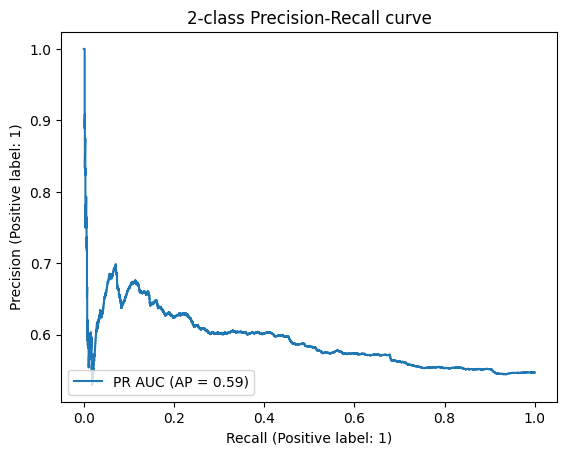

In [34]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.3
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.31
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.32
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.33
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.34
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.35
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.36
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.37
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.38
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.39
    prec_score: 0.54691
    obj_num: 7824
    obj_pct: 1.0
    obj_profit: 734
ic| bound: 0.4
    prec_score: 0.54691
    obj_num:

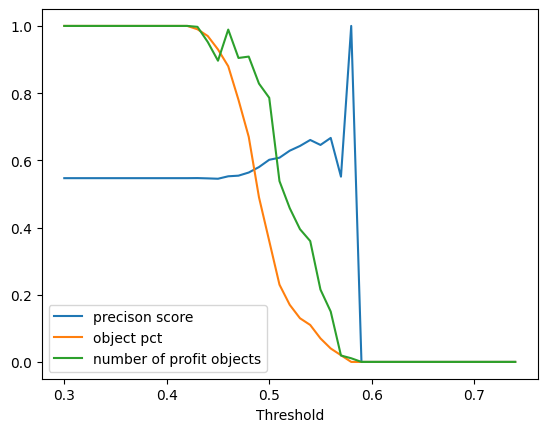

In [35]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round(obj_num * prec_score - obj_num * (1 - prec_score))
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [36]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])